In [1]:
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, ConcatDataset, Subset
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import time 
import pathlib
from PIL import Image
from sklearn import metrics
import os

In [2]:
#
# Defining the augmentations performed
# Takes an input dataset and multiplies its samples by the transformations
#
class augmented_dataset(Dataset):
    def __init__(self, targ_dir):
        self.paths = list(pathlib.Path(targ_dir).glob("*.jpg"))
        self.classes = ['Correct']
        self.class_to_idx = {'Classes':0}
        self.data = [(img, 'augm1') for img in self.paths]
        self.data.extend([(img, 'augm2') for img in self.paths])
        self.data.extend([(img, 'augm3') for img in self.paths])
        self.transform1 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.ColorJitter(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        self.transform2 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        self.transform3 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomVerticalFlip(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        if self.data[i][1] == 'augm1':
            img = Image.open(self.data[i][0])
            img = self.transform1(img)

        if self.data[i][1] == 'augm2':
            img = Image.open(self.data[i][0])
            img = self.transform2(img)

        if self.data[i][1] == 'augm3':
            img = Image.open(self.data[i][0])
            img = self.transform3(img)              

        return img,0


data_dir = "PetImages/RevisitedTraining"
correct_label_dir = "PetImages/RevisitedTraining/Correct"

#Loading normal dataset samples
dataset = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

#Augmenting the minority set and concantenating both datasets 
augmented_set = augmented_dataset(correct_label_dir)
concat_dataset = ConcatDataset([dataset, augmented_set])

#Using a reduced size of dataset when experimenting
size = 8000
correctsub = torch.randperm(len(augmented_set))[:size-1000]
incorrectsub = torch.randperm(len(dataset))[:size]
part1_subset = Subset(augmented_set, correctsub)
part2_subset = Subset(dataset,incorrectsub)
new_subset = ConcatDataset([part1_subset,part2_subset])
test, rest = random_split(new_subset, [10000, len(new_subset)-10000])
n = len(rest)
n_train = int(0.8 * n)
train, valid = random_split(rest, [n_train, n-n_train])


#Loading training and testing set into batches
train_dl = DataLoader(train, batch_size=64, num_workers=0, shuffle=True)
valid_dl = DataLoader(valid, batch_size=64, num_workers=0, shuffle=False)
test_dl = DataLoader(test, batch_size=64, num_workers=0, shuffle=False)


OOga 33216
112482
145698
Len of augment 7000
New subset length 5000
Train Len 4000
Valid Len 1000
Test Len 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


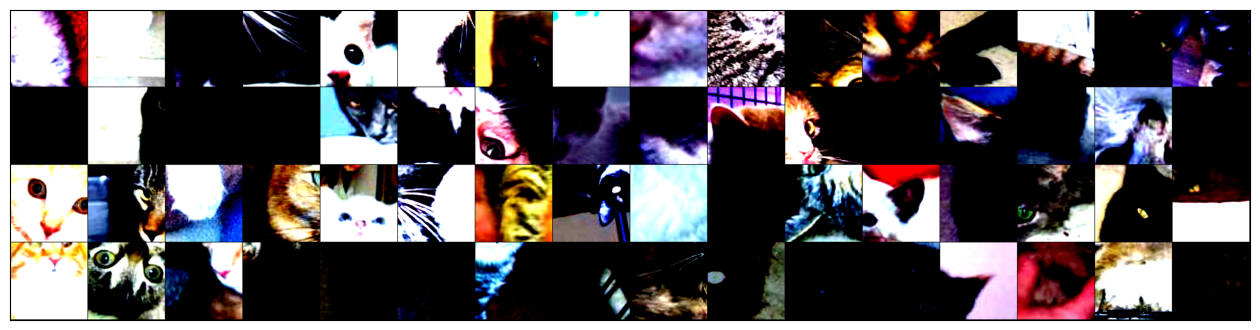

In [46]:
#
# Plotting a preview of the dataset batches
#
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [3]:
# Setup GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining checkpoints in training
def checkpoint(model, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, filename)

# Resuming the model at the current state and epoch
def resume(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

# Loading pretrained model
pretrained_model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

# Freeze model parameters
for param in pretrained_model.parameters():
    param.requires_grad = False

# Changing final layer of ResNet50 model for transfer learning
fc_inputs = pretrained_model.classifier[1].in_features
print("FC INPUT SIZE - ",fc_inputs)
pretrained_model.classifier = nn.Sequential(
    
    # Defining the final model structure with dropout, ReLu activation and neural network layers
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, 1024),
    nn.ReLU(),
    # nn.BatchNorm1d(1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    # nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
    # nn.Sigmoid()
)

# Convert model for use on GPU
pretrained_model = pretrained_model.to(device)

#Define Loss Function
loss_func = nn.CrossEntropyLoss()

#Tuning the optimiser with Adam, Adagrad and SGD
optimizer = optim.Adam(pretrained_model.parameters(), weight_decay=1e-5)
# optimizer = optim.Adagrad(pretrained_model.parameters(), weight_decay=1e-5)
# optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)


#
# Defining the training and validation steps of the zoom optimiser model
# Loads each batch of images in, trains the model, then backpropagates over the weights
# After each epoch, save the parameters in a checkpoint
# Returns the best epoch, the trained model and the accuracy and loss metrics over training
#
def train_and_validate(model, loss_criterion, optimizer, epochs=20, start_epoch = 0):
    
    if start_epoch > 0:
        start_epoch -= 1
        print("Resuming at model_{}.pt".format(start_epoch))
        resume(model, f"model_{start_epoch}.pt")

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(start_epoch,epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dl):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_dl):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save current model at each epoch for checkpoints
        path = 'model_'+str(epoch)+'.pt'
        checkpoint(model=model, filename=path)
        # torch.save(model.state_dict(),name)
            
    return model, history, best_epoch

FC INPUT SIZE -  1408


In [12]:
# Training the model
# Setting the start_epoch variable will determine any checkpoint epoch to start training from
num_epochs = 10
start_epoch = 0

trained_model, history, best_epoch = train_and_validate(pretrained_model, loss_func, optimizer, num_epochs, start_epoch)
print("THE BEST",best_epoch)
torch.save(history, 'history.pt')

Epoch: 1/8
Epoch : 001, Training: Loss - 0.5864, Accuracy - 69.7250%, 
		Validation : Loss - 0.5249, Accuracy - 72.5000%, Time: 69.4299s
Epoch: 2/8
Epoch : 002, Training: Loss - 0.5089, Accuracy - 75.2250%, 
		Validation : Loss - 0.5253, Accuracy - 71.2000%, Time: 28.7631s
Epoch: 3/8
Epoch : 003, Training: Loss - 0.4938, Accuracy - 75.8250%, 
		Validation : Loss - 0.5015, Accuracy - 75.7000%, Time: 30.3872s
Epoch: 4/8
Epoch : 004, Training: Loss - 0.4676, Accuracy - 77.6750%, 
		Validation : Loss - 0.5058, Accuracy - 76.3000%, Time: 25.1232s
Epoch: 5/8
Epoch : 005, Training: Loss - 0.4634, Accuracy - 77.9750%, 
		Validation : Loss - 0.5296, Accuracy - 75.9000%, Time: 24.9974s
Epoch: 6/8
Epoch : 006, Training: Loss - 0.4334, Accuracy - 79.6250%, 
		Validation : Loss - 0.5361, Accuracy - 75.1000%, Time: 28.4130s
Epoch: 7/8
Epoch : 007, Training: Loss - 0.4162, Accuracy - 80.3000%, 
		Validation : Loss - 0.5321, Accuracy - 76.0000%, Time: 29.2036s
Epoch: 8/8
Epoch : 008, Training: Loss - 

[[0.47879417091060766, 0.45155858082459965, 0.773191004975529, 0.7952233677221737], [0.45813966308862614, 0.4185607230335576, 0.7855301874873846, 0.8059106528881899], [0.4523288590948402, 0.4058006344832915, 0.7891922077492224, 0.8080068728768129], [0.44552856942714725, 0.41997943128916815, 0.7907708498740253, 0.809381443290776], [0.4431772655006813, 0.4018965587542229, 0.791941407671161, 0.8147766322860194], [0.43947415602440437, 0.4073819239688493, 0.793842221701042, 0.8138831615284137], [0.435177340863197, 0.4062334817709382, 0.7955712107141986, 0.8132989690557788], [0.4348981433846819, 0.40087567119663936, 0.7977619794175557, 0.8169072164866523], [0.4339397610713763, 0.3948532765714573, 0.7963122060130498, 0.8146391752413458], [0.43113080566621076, 0.40214101826612075, 0.7969243325698406, 0.8112027490999281]]


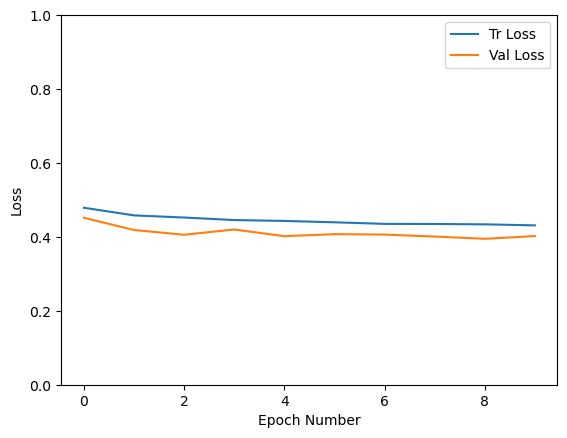

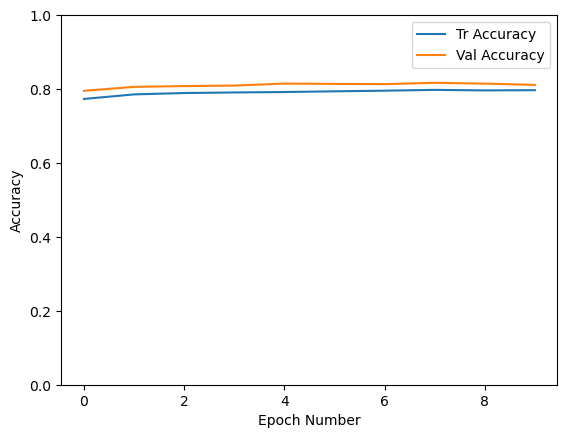

In [4]:
FOLDER_PATH = "Results/Final/"

# Display Loss over training
history = torch.load(FOLDER_PATH+"history.pt")
print(history)
history = np.array(history)

plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

# Display accuracy over training
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

# Loading the desired trained model epoch for predicting the test set 
trained_model = pretrained_model
checkpoint = torch.load(FOLDER_PATH+"model_7.pt")
trained_model.load_state_dict(checkpoint['model'])
truelabels = []
predictions = []
trained_model.eval()
classes = [0,1]

#
# Defining a function for serialising predictions to file
#
def serialise_values( output_file = None, values = None, probabilities = False, top5 = False) :
	f = open(output_file, "w")
	if probabilities:
		for label, prob in values:
			f.write(str(label)+" "+str(prob)+"\n")
	elif top5:
		for one, two, three, four, five in values:
			line = str(one[0]) + "|" + str(one[1]) + "|" + str(two[0]) + "|" + str(two[1]) +"|" +  str(three[0]) + "|" + str(three[1]) +"|" +  str(four[0]) + "|" + str(four[1]) + "|" + str(five[0]) + "|" + str(five[1]) + "\n"
			f.write(line)
	else:
		for label in values:
			f.write(str(label)+"\n")
	f.close()

#
# Defining a function for obtaining predictions from file
#
def get_predictions(input_file = None, probabilities = False, top5 = False):
	with open(input_file, 'r') as f:
		reader = f.readlines()
		label_list = []
		if probabilities:
			for line in reader:
				label = int(line[0])
				prob = float(line[2:-2])
				label_list.append([label, prob])
		elif top5:
			for line in reader:
				labels = []
				split = line.split("|")
				labels.append([split[0], float(split[1])])
				labels.append([split[2], float(split[3])])
				labels.append([split[4], float(split[5])])
				labels.append([split[6], float(split[7])])
				labels.append([split[8], float(split[9][:-2])])
				label_list.append(labels)
		else:			
			for line in reader:
				label_list.append(int(line[0]))
	return label_list

In [21]:
# Get true labels from test set and serialise for easy access
truelabels = []
for data, target in test_dl:
    for label in target.data.numpy():
        truelabels.append(label)
serialise_values(FOLDER_PATH+"true_labels.txt", truelabels)
# truelabels = get_predictions(FOLDER_PATH+"true_labels.txt")


predictions_with_prob = []
predictions = []

#
# Define function to iterate over test set and predict with trained model
# Returns the predictions for optimal or suboptimal and their probabilities
#
def predict_test_set():
    for data, target in test_dl:
        for input_batch in data:
            input_batch = input_batch.unsqueeze(0)
            input_batch = input_batch.to(device)
            # Make prediction
            with torch.no_grad():
                output = trained_model(input_batch)

            # Get predicted class
            _, indices = torch.sort(output, descending=True)
            _, predicted_class = torch.max(output, 1)
            percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
            top_percent = percentage[predicted_class.item()].item()
            predictions_with_prob.append([predicted_class.item(),top_percent])
    return predictions_with_prob

# Predict test set with trained model and serialise for easy access
predictions_with_prob = predict_test_set()
serialise_values(FOLDER_PATH+"predictions_with_prob.txt",values=predictions_with_prob,probabilities=True)
predictions_with_prob = get_predictions(FOLDER_PATH+"predictions_with_prob.txt", probabilities=True)

10000
10000


In [22]:
precision_scores = []
recall_scores = []
predictions = []
# Gets the best result of each prediction 
for pred in predictions_with_prob:
    predictions.append(pred[0])

# Iterating over the threshold values from 1-100, obtain the recall and precision scores
# This is used to plot the PR AUC curve
for p in range(1,100):
    test_preds = []

    for (pred, prob) in predictions_with_prob:
        if pred == 1:
            prob = 100 - prob
        if prob > p:
            test_preds.append(0)
        else:
            test_preds.append(1)
    recall = metrics.recall_score(truelabels, test_preds, pos_label=0, average='binary')
    precision = metrics.precision_score(truelabels, test_preds, pos_label=0, average='binary')
    # print(recall)
    # print(precision)
    precision_scores.append(precision)
    recall_scores.append(recall)

10000
10000


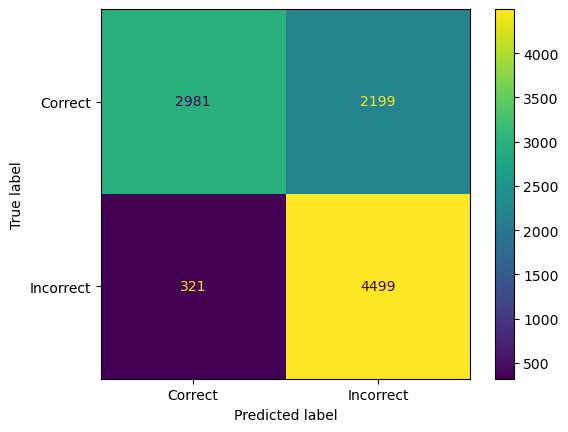

Recall Score: 0.5754826254826255
Precision Score: 0.902786190187765
Fbeta Score: 0.8977309320770469
F1 Score:
0.7029002593727894


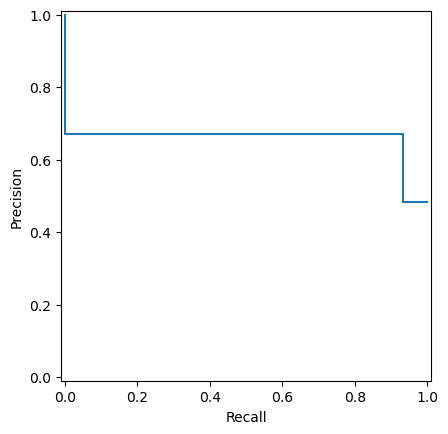

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Final AUC: 0.8


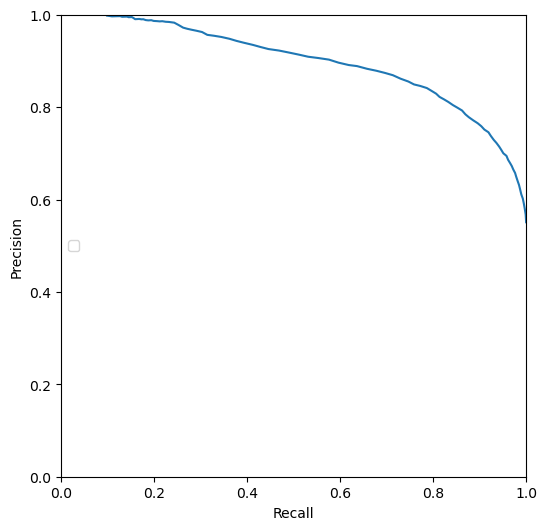

: 

In [23]:
# Using the metrics calculated above, display the confusion matrix, PR AUC curve, and other metrics
labels = ["Correct", "Incorrect"]
cm = metrics.confusion_matrix(truelabels, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
recall = metrics.recall_score(truelabels, predictions, pos_label=0, average='binary')
print("Recall Score:", recall)
precision = metrics.precision_score(truelabels, predictions, pos_label=0, average='binary')
print("Precision Score:", precision)
fbeta = metrics.fbeta_score(truelabels, predictions,beta=0.1, pos_label=0)
print("Fbeta Score:", fbeta)
print("F1 Score:")
f1 = metrics.f1_score(truelabels, predictions, pos_label=0,average='binary')
print(f1)
precision, recall, _ = metrics.precision_recall_curve(truelabels, predictions)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores)
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left')

print(f'Final AUC: {round(metrics.auc(recall_scores, precision_scores),2)}')

In [5]:
#
# Defines the prediction method for the test set
# Confidence threshold is tuned to improve accuracy
# Returns a set of crops it considers optimal
#

def predict(path):

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    zero_list = 0
    selected_images = []
    one_list = 0

    trained_model.eval()
    run = 0

    classes = [0,1]
    confidence_threshold = 54.1

    for i in range(0, 200):
        for j in range (0, 10):
            current_path = path + str(i)+"_"+str(j)+".jpg"
            image = Image.open(current_path)
            input_tensor = transform(image)
            input_batch = input_tensor.unsqueeze(0)
            input_batch = input_batch.to(device)

            # Make prediction
            with torch.no_grad():
                output = trained_model(input_batch)

            # Get predicted class
            _, indices = torch.sort(output, descending=True)
            _, predicted_class = torch.max(output, 1)
            percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
            top_percent = percentage[predicted_class.item()].item()
            if (predicted_class.item()) == 0 and top_percent > confidence_threshold:
                zero_list += 1
                selected_images.append(current_path)
            else:
                one_list += 1
            run += 1
    
    return selected_images


TEST_PATH = "PetImages/TestCropped/Cat/"
cropped_predictions = predict(TEST_PATH)

Zeroes :  252
Ones :  1748
Run 2000


In [ ]:
#
# Using ResNet to classify the original image vs the cropped versions
#
def guess_image(img):
    #Initialize model with the best available weights
    weights = models.ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)
    model.eval()

    #Initialize the inference transforms
    preprocess = weights.transforms()

    #Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0)

    #Obtain the top-5 predictions and returns them
    output = model(batch)
    output.shape
    _, indices = torch.sort(output, descending=True)
    _, predicted_class = torch.max(output, 1)
    percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
    top5 = [(weights.meta["categories"][idx], percentage[idx].item()) for idx in indices[0][:5]]
    print(top5)
    return top5

# Opens the ImageNet cat classes to compare ResNet's classifications to
with open('cat_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]

#
# Runs the guess_image function over a dataset
#
def guess_images(image_folder):
    results = []
    for img, lab in image_folder:
        results.append(guess_image(img))
    return results

uncropped_results = []

#
# Loads the test set into a dataset and uses ResNet to create an array of predictions
# 
UNCROPPED_PATH = "PetImages/TestCat/"
directory = os.fsencode(UNCROPPED_PATH)
for file in os.listdir(directory):
    filename = "PetImages/TestCat/Cat/" +os.fsdecode(file)
    # print(filename)
    img = Image.open(filename)
    uncropped_results.append(guess_image(img))

uncropped_images = ImageFolder(UNCROPPED_PATH, transform=transforms.Compose([
                transforms.Resize((256,256))
        ]))

# Serialises guessed uncropped results for easy access
uncropped_results = guess_images(uncropped_images)
serialise_values("uncropped_results.txt", uncropped_results, top5=True)
uncropped_results = get_predictions("uncropped_results.txt", top5=True)


[('Egyptian cat', 29.68157196044922), ('Siamese cat', 9.531381607055664), ('lynx', 3.5842645168304443), ('Angora', 1.7212493419647217), ('tiger cat', 1.4084925651550293)]
[('Egyptian cat', 20.991252899169922), ('tabby', 4.215367317199707), ('tiger cat', 3.805687665939331), ('lynx', 2.132248878479004), ('doormat', 1.9566946029663086)]
[('Egyptian cat', 24.10129165649414), ('tabby', 15.749144554138184), ('tiger cat', 4.544605731964111), ('lynx', 1.4836456775665283), ('tub', 0.20083144307136536)]
[('tabby', 37.81977081298828), ('tiger cat', 9.65024185180664), ('Egyptian cat', 4.639476776123047), ('space heater', 0.2958652675151825), ('carton', 0.27833500504493713)]
[('Egyptian cat', 15.664179801940918), ('tabby', 2.627997636795044), ('carton', 2.4014852046966553), ('Siamese cat', 2.3036932945251465), ('feather boa', 1.6402753591537476)]
[('lynx', 17.74625015258789), ('tabby', 8.549321174621582), ('Persian cat', 3.4454357624053955), ('tiger cat', 3.2678582668304443), ('Egyptian cat', 3.258

TypeError: serialise_values() got an unexpected keyword argument 'top5'

In [ ]:
#
# Use the ResNet classifier to guess on the cropped images
# Cropped images generated by zoom optimisation model
#
cropped_results = []
for path in cropped_predictions:
    img = Image.open(path)
    cropped_results.append(guess_image(img))

# Serialise predictions
serialise_values(FOLDER_PATH+"cropped_results.txt", cropped_results, top5=True)
cropped_results = get_predictions(FOLDER_PATH+"cropped_results.txt",top5=True)

In [ ]:
with open('cat_labels.txt') as f:
    cat_classes = [line.strip() for line in f.readlines()]

# Obtain the Top-1 and Top-3 accuracy for the original dataset and the cropped dataset
def accuracy_of_cats(arr):
    total_correct = 0
    within_5 = 0
    for top5 in arr:
        prediction = top5[0][0]
        pred2 = top5[1][0]
        pred3 = top5[2][0]
        if prediction in cat_classes:
            total_correct += 1
            within_5 += 1
        elif pred2 in cat_classes or pred3 in cat_classes:
            within_5 += 1

    print("Total Correct:", str(total_correct), " Len arr", len(arr))
    print("Total top 3", str(within_5))
    accuracy = total_correct / len(arr) * 100
    top_5_accuracy = within_5 / len(arr) * 100
    return accuracy, top_5_accuracy

cropped_accuracy, crop_top_5 = accuracy_of_cats(cropped_results)
print("Cropped TOP 1 accuracy: "+str(cropped_accuracy)+"%")
print("Cropped TOP 3 accuracy:"+str(crop_top_5)+"%")
uncropped_accuracy, uncrop_top_5 = accuracy_of_cats(uncropped_results)
print("Uncropped accuracy: "+str(uncropped_accuracy)+"%")
print("Uncropped TOP 3 accuracy:"+str(uncrop_top_5)+"%")

Total Correct: 157  Len arr 185
Total top 3 174
Cropped TOP 1 accuracy: 84.86486486486487%
Cropped TOP 3 accuracy:94.05405405405406%
Total Correct: 166  Len arr 200
Total top 3 184
Uncropped accuracy: 83.0%
Uncropped TOP 3 accuracy:92.0%
